# Fashion-MNIST Near Duplicates
## Exploring the effects of near duplicate removal on a popular ML dataset

![](https://imgur.com/961Exhb.png)

With this notebook you can easily train and visualize near-duplicates in the Fashion MNIST dataset. Please scroll to the "Viewing sorted pairs" section for more examples of near duplicate images.

MNIST and Fashion MNIST are extremely popular for testing in the machine
learning space. Fashion MNIST improves on MNIST by introducing a harder
problem, increasing the diversity of testing sets, and more accurately representing
a modern computer vision task. Near-duplicates between testing and training sets artificially increase the
testing accuracy of machine learning models. This notebook identifies near-duplicate
images in Fashion MNIST and you can refer to the [github repo](https://github.com/cpgeier/fair-fashion-mnist) for more information and additional scripts.

Running the full script saves dup files to your drive which are pickle files containing pairs of images sorted by similarity, which are used by other scripts in the Github repo.

### Training

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

4423680/4422102 [==============================] - 0s 0us/step


In [2]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v1 (Batc (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)    

In [3]:
import os

model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

def train_gen(batch_size):
  while True:
    offset = np.random.randint(0, x_train.shape[0] - batch_size)
    yield x_train[offset:offset+batch_size], y_train[offset:offset + batch_size]
    

model.fit_generator(
    train_gen(1024),
    epochs=1,
    steps_per_epoch=1000,
    validation_data=(x_test, y_test),
)

1000/1000 [==============================] - 147s 147ms/step - loss: 0.3229 - sparse_categorical_accuracy: 0.8899 - val_loss: 0.2443 - val_sparse_categorical_accuracy: 0.9192


In [0]:
model.save("model.h5")

### Feature vector by removing layers

In [0]:
max_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[-6].output)

### Sorting data to only compare similarly classified images

In [0]:
inds = y_train.argsort()
sorted_x_train = x_train[inds]
sorted_y_train = np.sort(y_train)

In [0]:
x_train_predictions = max_model.predict(sorted_x_train)

In [0]:
inds = y_test.argsort()
sorted_x_test = x_test[inds]
sorted_y_test = np.sort(y_test)

In [0]:
x_test_predictions = max_model.predict(sorted_x_test)

### Calculate and save distances between feature vectors

If demo is set to true you can move to the next section to view the results on the first image class.

In [22]:
demo = True # Set to false if you would like to save all labels
dups = []
j = 0
prev = 0
for i in range(len(sorted_x_train)):
    j = 1000 * sorted_y_train[i]
    while j < len(sorted_x_test) and sorted_y_test[j] == sorted_y_train[i]:
        dist = np.linalg.norm(x_train_predictions[i]-x_test_predictions[j])
        if i != j:
            dups.append([i,j,dist])
        j += 1
    if sorted_y_train[i] != prev:
      print("Saving: " + str(prev))
      dups.sort(key=lambda x: x[2])
      pickle_out = open("dups" + str(prev) + ".pickle","wb")
      pickle.dump(dups, pickle_out)
      pickle_out.close()
      if demo:
        break
      dups = []
    prev = sorted_y_train[i]
    if i % 10000 == 0:
      print("On image:",i)

if not demo:
  # Still need to save the last label...
  dups.sort(key=lambda x: x[2])
  pickle_out = open("dups" + str(prev) + ".pickle","wb")
  pickle.dump(dups, pickle_out)
  pickle_out.close()

On image: 0
Saving: 0


### Viewing sorted pairs

Distance: 0.53871244
First image index: 106
Second image index 850


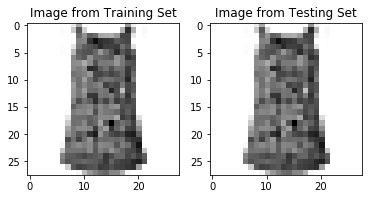

Distance: 3.2328997
First image index: 219
Second image index 788


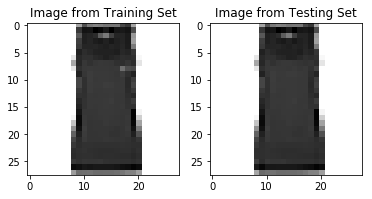

Distance: 7.716415
First image index: 2834
Second image index 149


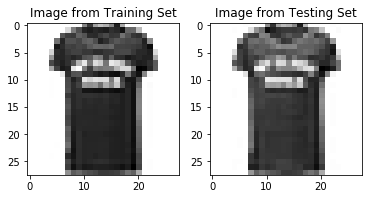

Distance: 7.7996144
First image index: 1016
Second image index 366


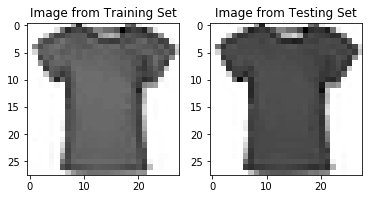

Distance: 8.384586
First image index: 3911
Second image index 788


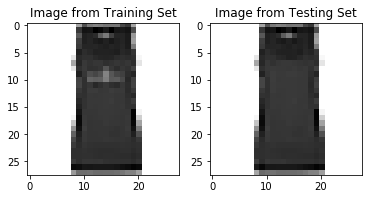

Distance: 9.069175
First image index: 5539
Second image index 122


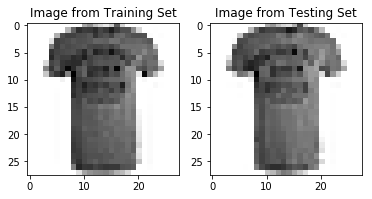

Distance: 10.759089
First image index: 445
Second image index 979


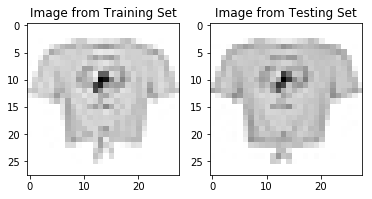

Distance: 10.772279
First image index: 533
Second image index 257


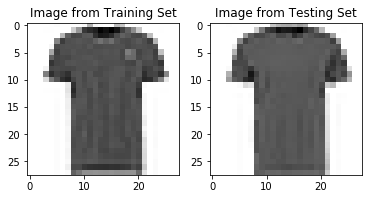

Distance: 11.041869
First image index: 453
Second image index 87


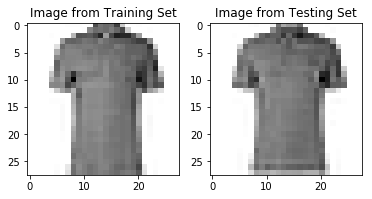

Distance: 11.127656
First image index: 1073
Second image index 616


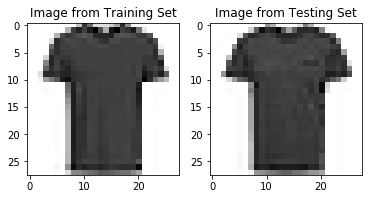

In [23]:
import matplotlib.pyplot as plt

# A good way to visually see that things are working above
for i in range(0,10):
    img_1 = np.squeeze(sorted_x_train[dups[i][0]], -1)
    img_2 = np.squeeze(sorted_x_test[dups[i][1]], -1)
    print('Distance:',dups[i][2])
    print('First image index:',dups[i][0])
    print('Second image index',dups[i][1])
    f, axarr = plt.subplots(1,2)
    axarr[0].title.set_fontsize(12)
    axarr[0].title.set_text("Image from Training Set")
    axarr[0].grid(False)
    axarr[0].imshow(img_1, cmap='gray_r')
    axarr[1].title.set_fontsize(12)
    axarr[1].title.set_text("Image from Testing Set")
    axarr[1].grid(False)
    axarr[1].imshow(img_2, cmap='gray_r')
    plt.show()

### Saving dup files to Google Drive

In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

In [0]:
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
    file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
    }
    media = MediaFileUpload(path, 
                  mimetype='application/octet-stream',
                  resumable=True)
    created = drive_service.files().create(body=file_metadata,
                                 media_body=media,
                                 fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created

In [0]:
for i in range(0,10):
  print(save_file_to_drive("dups"+str(i)+".pickle", "dups"+str(i)+".pickle"))

File ID: 1oi8B1B_BRLaj83ejij_pXVuX8T8AehFR
{'id': '1oi8B1B_BRLaj83ejij_pXVuX8T8AehFR'}
File ID: 1bhNVnhLC1OfNEPOxHAwIt8D-frxvWAi8
{'id': '1bhNVnhLC1OfNEPOxHAwIt8D-frxvWAi8'}
File ID: 1M1fUHhI-9Zfy3U9xgDCWqW5kXN5T-F9T
{'id': '1M1fUHhI-9Zfy3U9xgDCWqW5kXN5T-F9T'}
File ID: 1FdYteU4_gb9th2bNgTlSTR5BBchNfPvk
{'id': '1FdYteU4_gb9th2bNgTlSTR5BBchNfPvk'}
File ID: 1raHWlBTEc3miFBB_zIZkXYbuy6wa0evH
{'id': '1raHWlBTEc3miFBB_zIZkXYbuy6wa0evH'}
File ID: 1sxPiWauqVC_d3GoRqhG3bhJyewCWn0Nn
{'id': '1sxPiWauqVC_d3GoRqhG3bhJyewCWn0Nn'}
File ID: 1rD35VB4AqYiwzlTlJpKeKxPjzHw4i5bR
{'id': '1rD35VB4AqYiwzlTlJpKeKxPjzHw4i5bR'}
File ID: 1n8qZcbPfM6K4yWjbK4DSmNTuZtMWMLuf
{'id': '1n8qZcbPfM6K4yWjbK4DSmNTuZtMWMLuf'}
File ID: 1-TuH0pilsS_m7dnNKoC4VX9UegTJ7tPp
{'id': '1-TuH0pilsS_m7dnNKoC4VX9UegTJ7tPp'}
File ID: 1Q0_RYrDj7GCjhSDUlh9PADS2xNHHXRM5
{'id': '1Q0_RYrDj7GCjhSDUlh9PADS2xNHHXRM5'}
